
# Análise e Previsão de Sucesso de Startups


**Contexto:**

Uma aceleradora de stratups que já realizou o lançamento de diversas unicónios e empresas líderes globais, visa otimizar seus investimento e estratégias de aceleração apostando nas startups certas buscando maximizar seus resultados.

Com base no contexto apresentado, o objetivo deste notebook é realizar de forma assertiva a análise dos dados disponilizados para o desenvolvimento de um modelo preditivo capaz de identificar se uma Startup obterá sucesso ou não. Assim, segue todo o processo realizado para a obtenção de cada resultado.

# 1 - Carregamento e Explorção do Dados.

Neste primeiro momento, será realizado o carremento e exeploração dos dados para maior conhecimento da base de dados, a fim de desenvolver de forma assertiva a limpeza dos dados e os demais passos.

In [4]:
from google.colab import files
upload = files.upload()

Saving train.csv to train.csv


In [5]:
from google.colab import files
upload = files.upload()

Saving test.csv to test.csv


In [17]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score

# Carregamento dos datasets a partir das planilhas disponibilizadas na plataforma kaggle.

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Verificação das dimensões com o auxilio do (shape)
print("Verificação das dimensões (shape)")
print(f"Conjunto de treino (train) possui {train.shape[0]} linhas e {train.shape[1]} colunas")
print(f"Conjunto de teste (test) possui {test.shape[0]} linhas e {test.shape[1]} colunas")

# Resumo Técnico do DataFrame de Treino e Teste a partir do (.info)
print("\nResumo Técnico do DataFrame de Treino(.info)")
train.info()

print("\nResumo Técnico do DataFrame de Teste (.info)")
test.info()

# Visualização das primeiras linhas do conjunto de dados de treino e teste com o head
print("\nAmostra dos Dados")
print(train.head())

print("\nAmostra dos Dados Teste")
print(test.head())

Verificação das dimensões (shape)
Conjunto de treino (train) possui 646 linhas e 33 colunas
Conjunto de teste (test) possui 277 linhas e 32 colunas

Resumo Técnico do DataFrame de Treino(.info)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 646 entries, 0 to 645
Data columns (total 33 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        646 non-null    int64  
 1   age_first_funding_year    611 non-null    float64
 2   age_last_funding_year     637 non-null    float64
 3   age_first_milestone_year  508 non-null    float64
 4   age_last_milestone_year   535 non-null    float64
 5   relationships             646 non-null    int64  
 6   funding_rounds            646 non-null    int64  
 7   funding_total_usd         646 non-null    int64  
 8   milestones                646 non-null    int64  
 9   is_CA                     646 non-null    int64  
 10  is_NY                     646 non-nu


# 2 - Limpeza e Tratamento dos Dados

Após realizado o carregamento e a exploração inicial dos dados, é o momento de iniciar a limpeza e tratamento dos dados.

Assim, é possível visualizar o processo realizado na cécula abaixo com todos os detalhes documentados no código.

In [24]:

# Criação de novas colunas e tratamento de valores nulos
for df in [train, test]:
    df['funding_log1p'] = np.log1p(df['funding_total_usd'].fillna(0))
    df['rounds_per_relationship'] = df['funding_rounds'] / (df['relationships'].replace(0,1))
    df['milestones_per_year'] = df['milestones'] / ( (df['age_last_milestone_year'] - df['age_first_milestone_year']).replace(0,1).abs() + 1 )
    df['avg_participants_filled'] = df['avg_participants'].fillna(0)

# Realizada a redução de categorias da coluna category_code, visando  evitar a separação das variáveis em várias colunas.
top_n = 10
top_cats = train['category_code'].value_counts().index[:top_n].tolist()

def map_category(s):
    if pd.isna(s): return 'missing'
    if s in top_cats: return s
    return 'other'

train['category_code2'] = train['category_code'].apply(map_category)
test['category_code2'] = test['category_code'].apply(map_category)


De forma mais detalhada a respeito do processo de redução das categorias, o mesmo foi aplicado para evitar que as variáveis presentes nesta coluna sejam separadas em um conjunto extenso contendo cada variável alocada em uma coluna com valores binários, utilizando o One-Hot Encoding.

O processo aplicado ajuda a maximizar os resultados selecionando as 10 variáveis mais frequentes.

In [26]:
# Tratamento dos outliers usando IQR para funding_total_usd
print("\nTratamento de outliers em funding_total_usd:")
Q1 = train['funding_total_usd'].quantile(0.25)
Q3 = train['funding_total_usd'].quantile(0.75)
IQR = Q3 - Q1
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

outliers_antes = train[(train['funding_total_usd'] < limite_inferior) |
                       (train['funding_total_usd'] > limite_superior)].shape[0]
print(f"Outliers detectados: {outliers_antes}")
print(f"Mantendo outliers para preservar informação de grandes investimentos")


Tratamento de outliers em funding_total_usd:
Outliers detectados: 50
Mantendo outliers para preservar informação de grandes investimentos


Como pode ser visto na cécula acima, foi realizado o tratamento dos outliers. Como visto no terminal, por se tratater de uma quantidade alta (50), os mesmo foram mantidos a fim de preservar informações de grandes investimentos, dados relevantes para a predição do modelo, visando resultados assertivos finais.

Após o processo anterior, é necessário tratar os valores ausentes (NaN) nas colunas numéricas, substituindo-os pela mediana de cada coluna no conjunto de treinamento, como visto na célula abaixo.

In [27]:
# Separar colunas numéricas
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()

# Imputar valores numéricos com a mediana
imp = SimpleImputer(strategy='median')
X_num = pd.DataFrame(imp.fit_transform(X[num_cols]), columns=num_cols)
X_test_num = pd.DataFrame(imp.transform(X_test[num_cols]), columns=num_cols)

print("Imputação de valores nulos em colunas numéricas realizada.")

Imputação de valores nulos em colunas numéricas realizada.


##### **2.1 - Codificação de Variáveis Categóricas**

Abaixo é possível visualizar a aplicação, da técnica de One-Hot Encoding à coluna categórica `category_code2`.

Este processo faz com que a única coluna categórica se transforme em várias colunas binárias, onde cada coluna representa uma categoria única com valores binários.

In [ ]:
# Separar colunas categóricas
cat_cols = ['category_code2']

# One-hot encoding para categóricas
ohe = OneHotEncoder(handle_unknown='ignore')
X_cat = pd.DataFrame(ohe.fit_transform(X[cat_cols]).toarray(), columns=ohe.get_feature_names_out(cat_cols))
X_test_cat = pd.DataFrame(ohe.transform(X_test[cat_cols]).toarray(), columns=ohe.get_feature_names_out(cat_cols))

print("Codificação de variáveis categóricas realizada.")

##### **2.3 - Combinação de Features e Limpeza Final**

Como pode ser visto abaixo, foi realizada a combinação das features numéricas sem os valores nulos e as features categóricas codificadas em um único conjunto de dados processado.

Também é importante remover as colunas que se tornaram constantes após a limpeza e tratamento dos dados, pois elas não contribuem para a previsão.

In [ ]:
# Concatenar features numéricas e categóricas
X_proc = pd.concat([X_num.reset_index(drop=True), X_cat.reset_index(drop=True)], axis=1)
X_test_proc = pd.concat([X_test_num.reset_index(drop=True), X_test_cat.reset_index(drop=True)], axis=1)

# Remover colunas constantes
X_proc = X_proc.loc[:, X_proc.nunique()>1]
X_test_proc = X_test_proc[X_proc.columns]

print("Combinação de features e remoção de colunas constantes realizada.")
print("Número final de features após pré-processamento:", X_proc.shape[1])

# 3 - Exploração e Visualização dos Dados

Neste momento, será realizada a exploração e visualização dos dados, permitindo um conhecimento maior acerca dos dados disponíveis após a limpeza, ajudando na fomulação das hipóteses.

##### **3.1 - Estatítica descritiva e distribuição da variável target**


Estatísticas descritivas das variáveis numéricas:
               id  age_first_funding_year  age_last_funding_year  \
count  646.000000              611.000000             637.000000   
mean   461.577399                2.341718               4.037724   
std    264.859464                2.468275               2.950923   
min      1.000000                0.000000               0.000000   
25%    233.250000                0.680000               1.870000   
50%    459.500000                1.650000               3.610000   
75%    692.500000                3.600000               5.590000   
max    923.000000               21.900000              21.900000   

       age_first_milestone_year  age_last_milestone_year  relationships  \
count                508.000000               535.000000     646.000000   
mean                   3.352657                 4.944729       7.948916   
std                    2.866952                 3.213319       7.397602   
min                    0.000000     

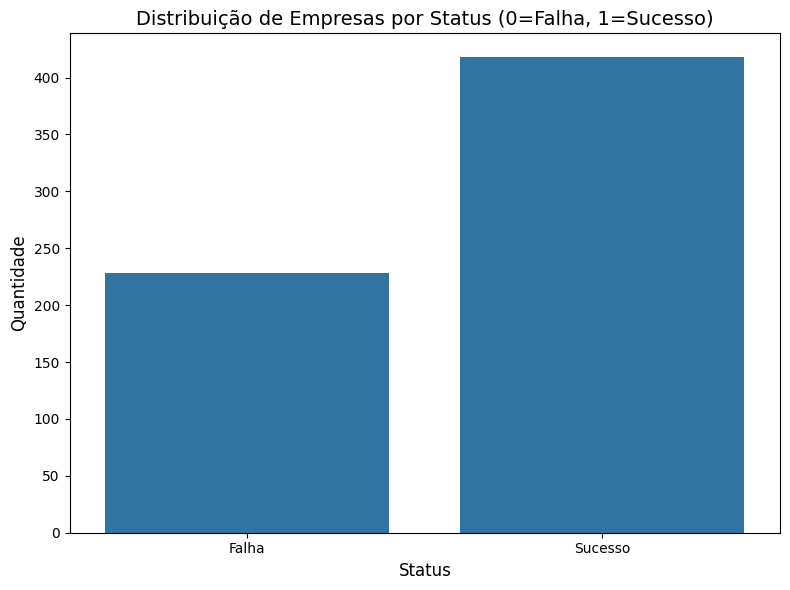

In [29]:

# Estatísticas descritivas
print("\nEstatísticas descritivas das variáveis numéricas:")
print(train.describe())

# Distribuição da variável target
print("\nDistribuição da variável target (labels):")
print(train['labels'].value_counts())
print(f"\nProporção de sucesso: {train['labels'].mean():.2%}")

# Distribuição variável target
plt.figure(figsize=(8, 6))
sns.countplot(data=train, x='labels')
plt.title('Distribuição de Empresas por Status (0=Falha, 1=Sucesso)', fontsize=14)
plt.xlabel('Status', fontsize=12)
plt.ylabel('Quantidade', fontsize=12)
plt.xticks([0, 1], ['Falha', 'Sucesso'])
plt.tight_layout()
plt.show()

O gráfico acima auxilia a visualizar as taxas de falha e sucesso na base de dados. A partir do gráfico gerado é possível observar a presença de mais empresas que obtiveram sucesso do que fracasso.

##### **3.2 - Boxplot Financiamento Total por Status da Empresa.**

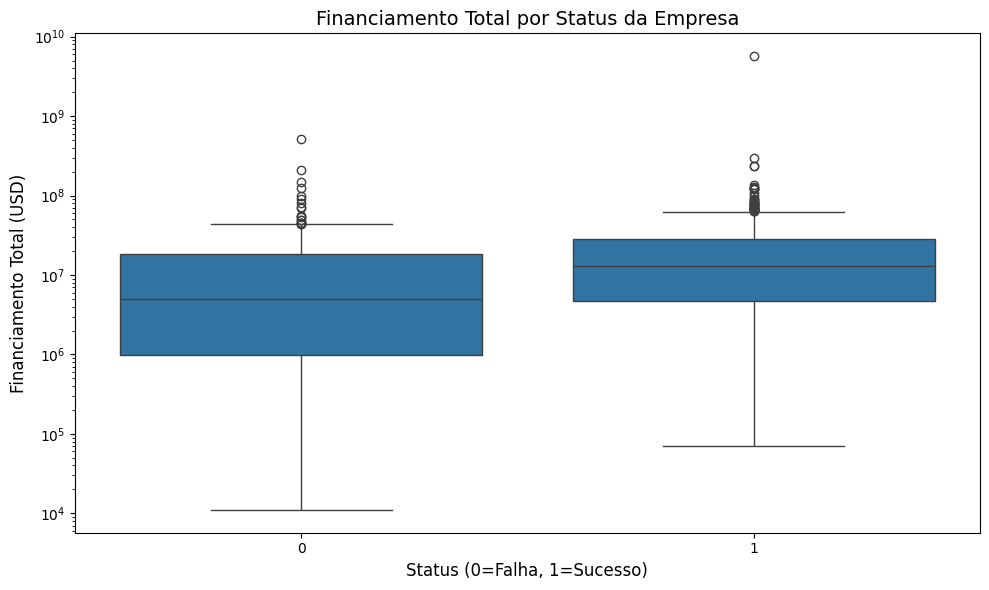

In [30]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=train, x='labels', y='funding_total_usd')
plt.title('Financiamento Total por Status da Empresa', fontsize=14)
plt.xlabel('Status (0=Falha, 1=Sucesso)', fontsize=12)
plt.ylabel('Financiamento Total (USD)', fontsize=12)
plt.yscale('log')
plt.tight_layout()
plt.show()

O gráfico acima se trata de um boxplot, neste boxplot é possível observar que a mediana para empresa de sucesso é superior em casos de maior investimento se comparadas com empresas com menos investimento.

##### **3.3 - Empresas por categoria.**

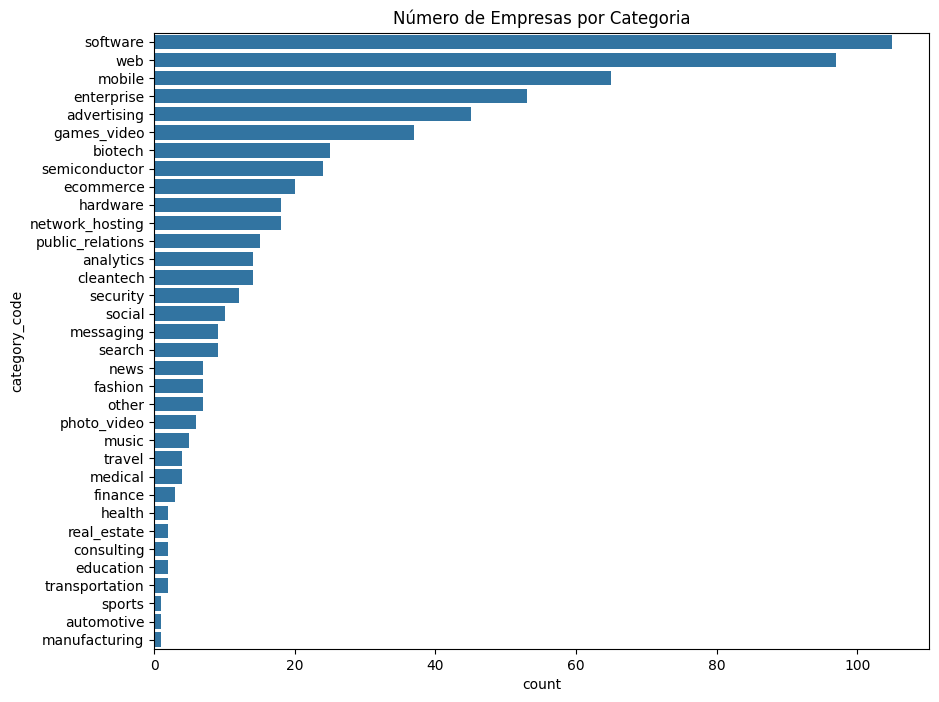

In [31]:
plt.figure(figsize=(10, 8))

sns.countplot(data=train, y='category_code', order=train['category_code'].value_counts().index)
plt.title('Número de Empresas por Categoria')
plt.show()

A visualização da distribuição de startups por categoria demonstra que empresas na área de software e web estão em maior quantidade.

##### 3.4 -  **Matriz de correlção das várias variáveis**


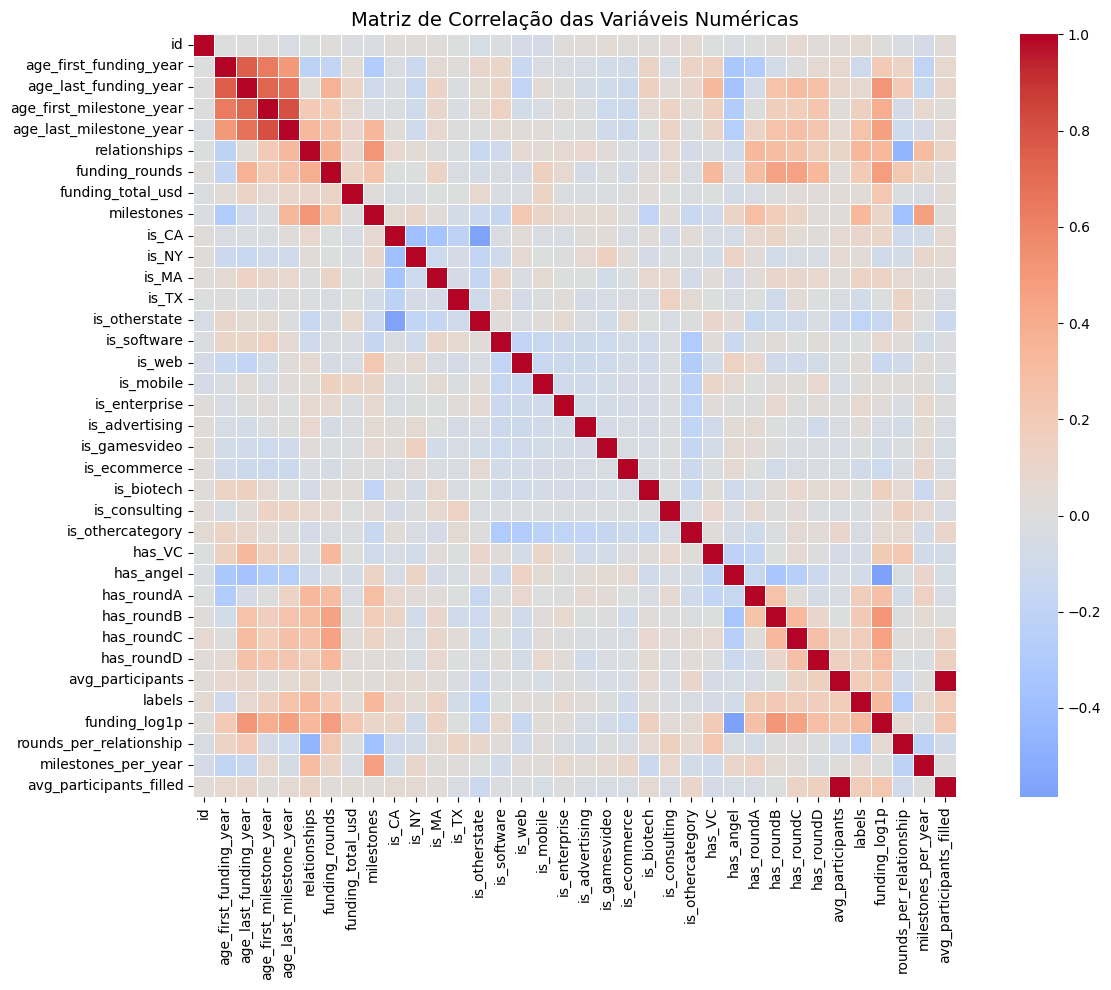

In [32]:
plt.figure(figsize=(14, 10))
correlation_matrix = train.select_dtypes(include=np.number).corr()
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0,
            square=True, linewidths=0.5)
plt.title('Matriz de Correlação das Variáveis Numéricas', fontsize=14)
plt.tight_layout()
plt.show()


A matriz de correlação acima, compõe a análise demonstando a correlação entre várias variáveis presentes no conjunto de dados.

##### **3.5 Taxa média de sucesso por empresa.**

/tmp/ipython-input-2720763640.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(state_success.keys()), y=list(state_success.values()), palette="viridis")


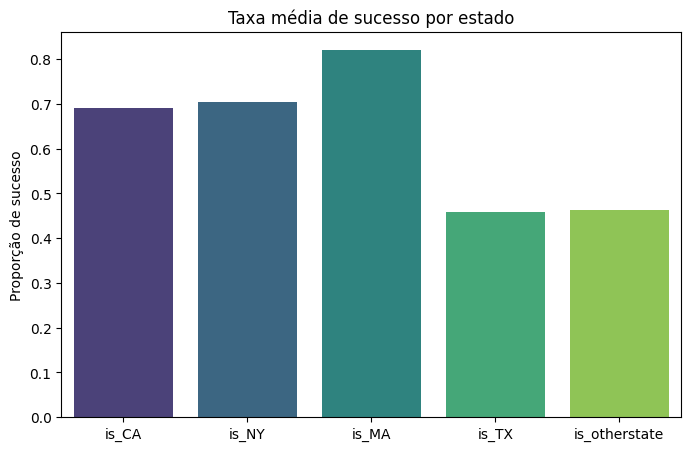

In [33]:
state_cols = ["is_CA", "is_NY", "is_MA", "is_TX", "is_otherstate"]
state_success = {}
for col in state_cols:
    taxa = train.groupby(col)["labels"].mean()[1] if train[col].sum() > 0 else 0
    state_success[col] = taxa

plt.figure(figsize=(8,5))
sns.barplot(x=list(state_success.keys()), y=list(state_success.values()), palette="viridis")
plt.title("Taxa média de sucesso por estado")
plt.ylabel("Proporção de sucesso")
plt.show()

##### **3.6 - Taxa Média de Sucesso por Estado.**

/tmp/ipython-input-2720763640.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(state_success.keys()), y=list(state_success.values()), palette="viridis")


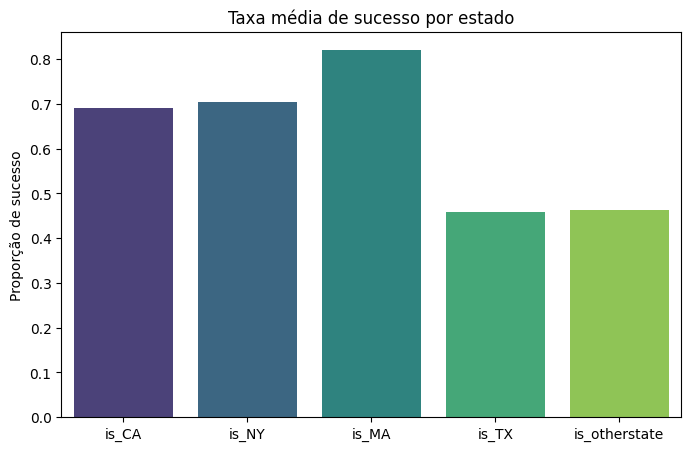

In [34]:
state_cols = ["is_CA", "is_NY", "is_MA", "is_TX", "is_otherstate"]
state_success = {}
for col in state_cols:
    taxa = train.groupby(col)["labels"].mean()[1] if train[col].sum() > 0 else 0
    state_success[col] = taxa

plt.figure(figsize=(8,5))
sns.barplot(x=list(state_success.keys()), y=list(state_success.values()), palette="viridis")
plt.title("Taxa média de sucesso por estado")
plt.ylabel("Proporção de sucesso")
plt.show()

O último gráfico gerado diz respeito a distribuição de startups de sucesso por estado, sendo possível visualizar que o estado de Massachusetts conta com o maior índice de sucesso.

# 4 - Hipóteses

As hipóteses são suposições sobre determinados parâmetros, que pode ser testada a partir dos dados disponíveis para que seja validada ou não. Assim, segue as hipóteses levantas e suas respctivas explicações.

##### **4.1 - Empresas no segmento de tecnologia possuem maior índice de sucesso.**
 A primeira hipótese levantada refere-se a relação entre o segmento da empresa e o seu índice de sucesso.

 Esta hipótese fundamenta-se na ideia de que empresas alocadas nos setores de tecnologia apresentam maiores índices de sucesso, visto que a tecnologia não só está presente em todo o mercado, como é o futuro.

 Assim, para averiguar se as empresas nos segmentos de tecnologia possuem de fato maior índice de sucesso ou não, o gráfico a seguir realiza a exploração dessa relação.

Text(0, 0.5, 'Categoria')

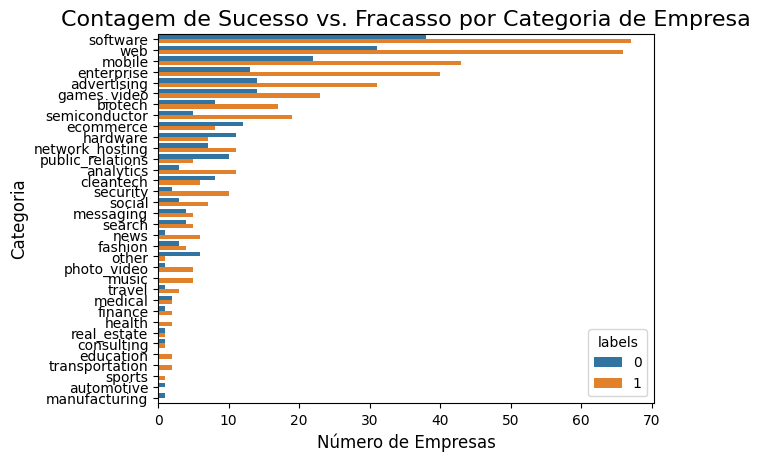

In [35]:
sns.countplot(y='category_code',
              data=train,
              order=train['category_code'].value_counts().index,
              hue='labels')

plt.title('Contagem de Sucesso vs. Fracasso por Categoria de Empresa', fontsize=16)
plt.xlabel('Número de Empresas', fontsize=12)
plt.ylabel('Categoria', fontsize=12)

Como pode ser observado no gráfico acima, a hipótese comprova-se verdadeira visto que os ídices de sucesso em empresa dos segmentos de tecnologia como: software, web, mobile e game videos, biotech e etc. É maior comparada as demais.

##### **4.2 - Empresas localizadas no estado do Texas tendem a ter maior número de fracassos.**

Com base no gráfico que mostra a taxa de sucesso de startups por estado, o estado do Texas apresenta-se em menor número de sucessos.

Desse modo, foi levantada a hipótese de que o mesmo apresenta maior número de fracassos e por isso está colocado entre as menores taxas de sucesso.

Assim, o gráfico a seguir comprova a veracidade desta relação.

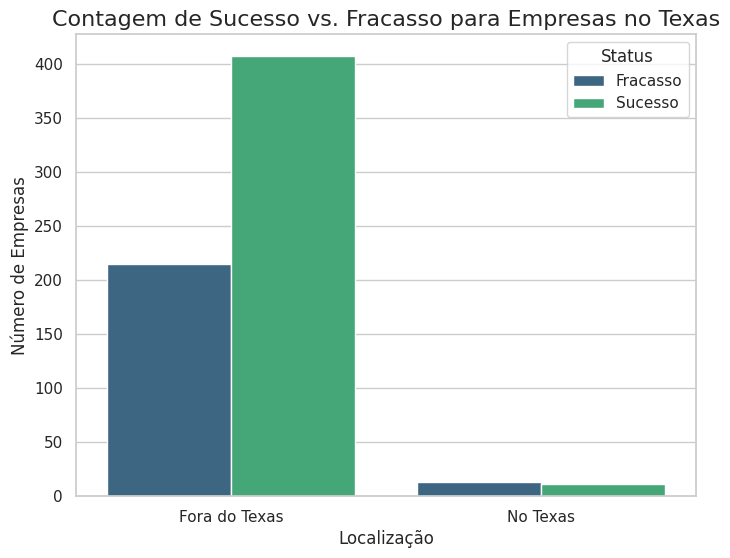

In [36]:
sns.set_theme(style="whitegrid")

# Cria uma figura
plt.figure(figsize=(8, 6))

# Gera o countplot focado na coluna 'is_TX'
sns.countplot(data=train, x='is_TX', hue='labels', palette='viridis')

# Melhora os títulos e rótulos
plt.title('Contagem de Sucesso vs. Fracasso para Empresas no Texas', fontsize=16)
plt.xlabel('Localização', fontsize=12)
plt.ylabel('Número de Empresas', fontsize=12)
plt.xticks(ticks=[0, 1], labels=['Fora do Texas', 'No Texas'])
plt.legend(title='Status', labels=['Fracasso', 'Sucesso'])

Com base no gráfico gerado acima, a hipótese comprova-se verdadeira visto que empresas no Texas apresentam maior índice de fracasso se comparada com as demais regiões mapeadas.

##### **4.3 - Empresas com maior investimento tendem ao sucesso.**
A partir do boxplot gerado que evidência a relação entre investimento e sucesso da empresa, fundamenta-se assim a terceira hipótese, que diz que, quanto maior o investimento, maior o sucesso. Assim, o gráfico a seguir explora esta relação buscando verificar sua veracidade.

/tmp/ipython-input-3046795631.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=train,


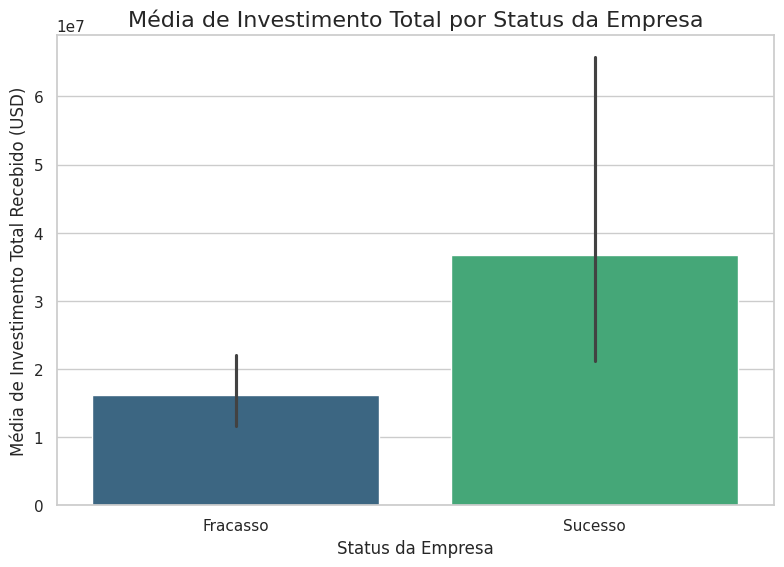

In [37]:
sns.set_theme(style="whitegrid")

plt.figure(figsize=(8, 6))

sns.barplot(data=train,
            x='labels',
            y='funding_total_usd',
            palette='viridis')

plt.title('Média de Investimento Total por Status da Empresa', fontsize=16)
plt.xlabel('Status da Empresa', fontsize=12)
plt.ylabel('Média de Investimento Total Recebido (USD)', fontsize=12)
plt.xticks(ticks=[0, 1], labels=['Fracasso', 'Sucesso'])

plt.tight_layout()

plt.show()

Como pode ser observadono gráfico acima, empresas com maior número de investimento possuem maior indice de sucesso, confirmando assim a hipótese levantada.

# 5 - Seleção de Features

Com base nos processos realizados anteriormente, este é o momento da seleção final das features pré-selecionadas anteriormente.

As features selecionadas foram:

- age_first_funding_year
- age_last_funding_year
- age_first_milestone_year
- age_last_milestone_year
- relationships
- funding_rounds
- funding_total_usd
- milestones
- is_CA
- is_NY
- is_MA
- is_TX
- is_otherstate
- is_software
- is_web
- is_mobile
- is_enterprise
- is_advertising
- is_gamesvideo
- is_ecommerce
- is_biotech
- is_consulting
- is_othercategory
- has_VC
- has_angel
- has_roundA
- has_roundB
- has_roundC
- has_roundD
- avg_participants
- funding_log1p
- rounds_per_relationship
- milestones_per_year
- avg_participants_filled
- category_code2

In [38]:
# Features finais selecionadas
features = [c for c in train.columns if c not in ['id','labels','category_code']]
X = train[features].copy()
y = train['labels'].copy()
X_test = test[features].copy()

print("Número de features antes do pré-processamento:", len(features))

print(features)

Número de features antes do pré-processamento: 35
['age_first_funding_year', 'age_last_funding_year', 'age_first_milestone_year', 'age_last_milestone_year', 'relationships', 'funding_rounds', 'funding_total_usd', 'milestones', 'is_CA', 'is_NY', 'is_MA', 'is_TX', 'is_otherstate', 'is_software', 'is_web', 'is_mobile', 'is_enterprise', 'is_advertising', 'is_gamesvideo', 'is_ecommerce', 'is_biotech', 'is_consulting', 'is_othercategory', 'has_VC', 'has_angel', 'has_roundA', 'has_roundB', 'has_roundC', 'has_roundD', 'avg_participants', 'funding_log1p', 'rounds_per_relationship', 'milestones_per_year', 'avg_participants_filled', 'category_code2']


# 6 Construção e Avaliação do Modelo

##### **6.1 - Modelo de regressão logística**

O modelo de regressão logistica é uma tecnica de aplicação supervisionada utilizada na previsão da probabilidade de um evento ocorrer ou não se forma binária, sendo ideal para aplicação neste projeto.

In [20]:

# Logistic Regression com pipeline (scaling + LR)
lr_pipe = make_pipeline(StandardScaler(), LogisticRegression(max_iter=2000, solver='liblinear', random_state=42))

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores_lr = cross_val_score(lr_pipe, X_proc, y, cv=skf, scoring='accuracy')

print("Logistic Regression CV accuracy:", scores_lr.mean(), "+-", scores_lr.std())


Logistic Regression CV accuracy: 0.7430053667262969 +- 0.020183260472157488


##### **6.2 - Random Forest**

O Random Forest também se trata de um modelo supervisionado que utiliza um conjunto de múltiplas árvores de decisão para fazer previsões mais precisas se comparadas ao de uma única árvore, apresentando uma boa aplicação para os resultados esperados.

In [39]:

# Random Forest
rf = RandomForestClassifier(
    n_estimators=400,
    max_depth=12,
    min_samples_split=5,
    random_state=42,
    n_jobs=-1
)

scores_rf = cross_val_score(rf, X_proc, y, cv=skf, scoring='accuracy')

print("Random Forest CV accuracy:", scores_rf.mean(), "+-", scores_rf.std())


Random Forest CV accuracy: 0.7894335122242099 +- 0.025001365201286572


##### **6.3 - Finetuning de Hiperparâmetros**

Por fim, será utilizado o GridSearchCV para encontrar a melhor combinação de hiperparâmetros para o modelo de Random Forest.

Assim, foi definido um espaço de busca para alguns dos hiperparâmetros mais importantes em conjunto com a validação cruzada para avaliar cada combinação.

In [41]:
from sklearn.model_selection import GridSearchCV


# Definir o espaço de hiperparâmetros para o Random Forest
param_grid = {
    'n_estimators': [200, 400, 600],
    'max_depth': [10, 12, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# GridSearchCV
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='accuracy',
    cv=skf,
    n_jobs=-1,
    verbose=2
)

print("GridSearchCV configurado. Pronto para executar o ajuste fino.")

GridSearchCV configurado. Pronto para executar o ajuste fino.


## 6.4 - Executando o Finetuning

Abaixo foi executado o GridSearchCV nos dados de treino processados.

In [42]:

grid_search.fit(X_proc, y)

print("\nAjuste fino concluído.")
print("Melhores hiperparâmetros encontrados:", grid_search.best_params_)
print("Melhor acurácia na validação cruzada:", grid_search.best_score_)

# Obter o melhor modelo
best_rf_model = grid_search.best_estimator_

Fitting 5 folds for each of 81 candidates, totalling 405 fits

Ajuste fino concluído.
Melhores hiperparâmetros encontrados: {'max_depth': 12, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}
Melhor acurácia na validação cruzada: 0.798747763864043


##### **6.5 - Avaliação do Melhor Modelo e Previsões Finais**

A partir da identifcação do melhor modelo através do GridSearchCV, o mesmo será utilizado para fazer as previsões no conjunto de teste e gerar o arquivo de submissão.

In [43]:
pred_test = best_rf_model.predict(X_test_proc)

# Criar submission
submission = pd.DataFrame({'id': test['id'], 'labels': pred_test})
submission.to_csv('submission.csv', index=False)

print("Arquivo submission.csv gerado com previsões do melhor modelo!")
display(submission.head())

Arquivo submission.csv gerado com previsões do melhor modelo!


,id,labels
0,70,1
1,23,0
2,389,1
3,872,1
4,920,0


In [44]:
from google.colab import files

files.download('submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Conclusão

Após a submissão do arquivo na plataforma, o mesmo não atingiu a acurácia mínima esperada pelo Kaggle tendo seu valor máximo alcançado de 0.77536.